# How to extract a file

In [1]:
# !apt install unzip

In [2]:
# !unzip -q "/content/data.zip"

# Download github files & datasets

uncomment the following code to download the files 
(remove the `#` for download data sets)

In [3]:
# !apt install git

In [4]:
# !git clone "https://github.com/rezapace/Machine-Learning-Sound-Detection"

# Running the Sound Detection Program

In [21]:
import os
import pathlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers, models
from IPython import display

In [22]:
# Set the seed value for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Path to the dataset
DATASET_PATH = '/content/Machine-Learning-Sound-Detection/data'

data_dir = pathlib.Path(DATASET_PATH)
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['firetruck' 'ambulance' 'traffic']


In [23]:
# Load dataset
def decode_audio(audio_binary):
    audio, _ = tf.audio.decode_wav(audio_binary, desired_channels=1)
    return tf.squeeze(audio, axis=-1)

def get_waveform_and_label(file_path):
    label = tf.strings.split(file_path, os.path.sep)[-2]
    label = tf.argmax(label == commands)  # Convert label to integer
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, label

def get_dataset(data_dir):
    files = tf.data.Dataset.list_files(str(data_dir/'*/*'))
    output_ds = files.map(get_waveform_and_label, num_parallel_calls=tf.data.AUTOTUNE)
    return output_ds

In [24]:
# Split dataset into training, validation, and test sets
full_ds = get_dataset(data_dir)
full_ds = full_ds.shuffle(buffer_size=10000, seed=seed, reshuffle_each_iteration=False)
full_ds_size = len(list(full_ds))

train_size = int(0.8 * full_ds_size)
val_size = int(0.1 * full_ds_size)
test_size = full_ds_size - train_size - val_size

train_ds = full_ds.take(train_size)
val_ds = full_ds.skip(train_size).take(val_size)
test_ds = full_ds.skip(train_size + val_size)

print(f"Train size: {train_size}, Validation size: {val_size}, Test size: {test_size}")

Train size: 480, Validation size: 60, Test size: 61


In [25]:
# Preprocess dataset
def get_spectrogram(waveform):
    spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.image.resize(spectrogram[..., tf.newaxis], [1032, 129])  # Resize to expected shape
    return spectrogram

def make_spec_ds(ds):
    return ds.map(lambda audio, label: (get_spectrogram(audio), label), num_parallel_calls=tf.data.AUTOTUNE)

train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

In [26]:
# Add a dimension to the input spectrogram
def add_batch_dimension(spectrogram, label):
    spectrogram = tf.expand_dims(spectrogram, -1)  # Add channel dimension
    return spectrogram, label

train_spectrogram_ds = train_spectrogram_ds.map(add_batch_dimension)
val_spectrogram_ds = val_spectrogram_ds.map(add_batch_dimension)
test_spectrogram_ds = test_spectrogram_ds.map(add_batch_dimension)

In [27]:
# Cache, shuffle, and prefetch the datasets
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).batch(32).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)

In [28]:
# Build the model
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
    input_shape = example_spectrograms.shape[1:]

num_labels = len(commands)

model = models.Sequential([
    layers.Input(shape=(input_shape[0], input_shape[1], 1)),  # Add channel dimension
    layers.Resizing(32, 32),
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 flatten_1 (Flatten)         (None, 12544)             0         
                                                      

In [29]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [30]:
# Check the number of elements in the dataset
print(f"Number of elements in train dataset: {len(list(train_spectrogram_ds))}")
print(f"Number of elements in validation dataset: {len(list(val_spectrogram_ds))}")
print(f"Number of elements in test dataset: {len(list(test_spectrogram_ds))}")

Number of elements in train dataset: 15
Number of elements in validation dataset: 2
Number of elements in test dataset: 2


In [31]:
# Path to the dataset
DATASET_PATH = '/content/Machine-Learning-Sound-Detection/data'
data_dir = pathlib.Path(DATASET_PATH)
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['firetruck' 'ambulance' 'traffic']


In [32]:
# Train the model
EPOCHS = 100
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/100
15/15 [==============================] - 3s 155ms/step - loss: 0.8397 - accuracy: 0.6500 - val_loss: 0.5236 - val_accuracy: 0.8333
Epoch 2/100
15/15 [==============================] - 3s 180ms/step - loss: 0.4641 - accuracy: 0.8396 - val_loss: 0.3034 - val_accuracy: 0.9000
Epoch 3/100
15/15 [==============================] - 2s 108ms/step - loss: 0.3077 - accuracy: 0.8938 - val_loss: 0.1941 - val_accuracy: 0.9333
Epoch 4/100
15/15 [==============================] - 2s 114ms/step - loss: 0.2840 - accuracy: 0.9104 - val_loss: 0.1628 - val_accuracy: 0.9333
Epoch 5/100
15/15 [==============================] - 2s 125ms/step - loss: 0.2224 - accuracy: 0.9271 - val_loss: 0.1416 - val_accuracy: 0.9333
Epoch 6/100
15/15 [==============================] - 3s 193ms/step - loss: 0.2227 - accuracy: 0.9292 - val_loss: 0.1273 - val_accuracy: 0.9333
Epoch 7/100
15/15 [==============================] - 2s 126ms/step - loss: 0.2027 - accuracy: 0.9375 - val_loss: 0.1332 - val_accuracy: 0.9333

Text(0, 0.5, 'Accuracy [%]')

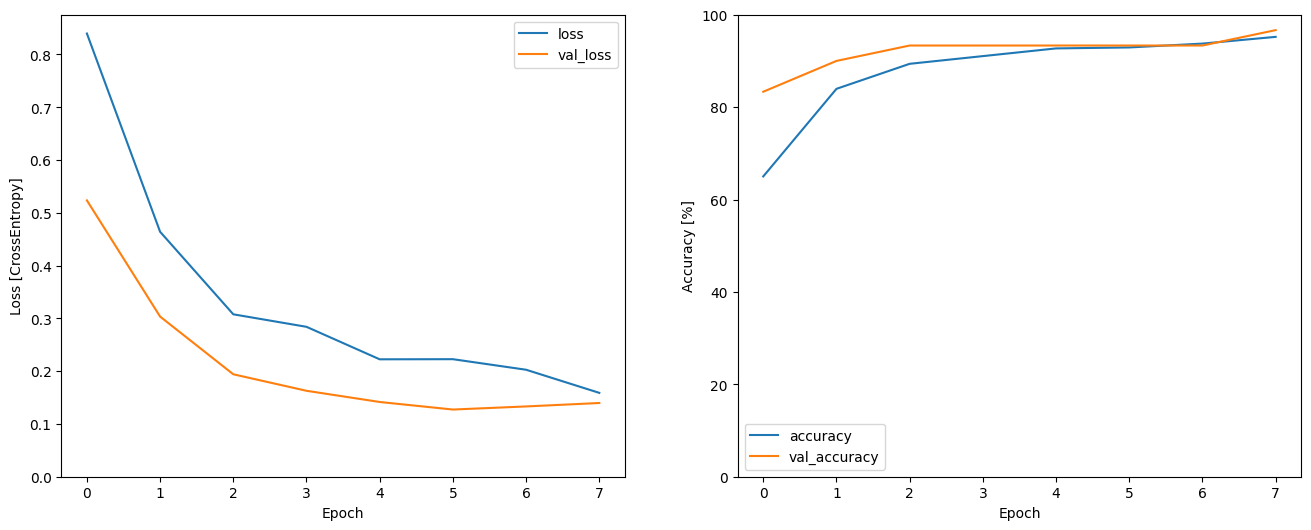

In [33]:
# Evaluate the model
metrics = history.history
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1, 2, 2)
plt.plot(history.epoch, 100 * np.array(metrics['accuracy']), 100 * np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [34]:
# Evaluate on test set
model.evaluate(test_spectrogram_ds, return_dict=True)

2/2 [==============================] - 0s 46ms/step - loss: 0.0787 - accuracy: 0.9672


{'loss': 0.07874611765146255, 'accuracy': 0.9672130942344666}

In [38]:
from sklearn.metrics import classification_report

# Prediksi pada data validasi atau test
y_true = []  # Label asli
y_pred = []  # Prediksi model

for spectrograms, labels in test_spectrogram_ds:
    predictions = model.predict(spectrograms)
    y_true.extend(labels.numpy())
    y_pred.extend(tf.argmax(predictions, axis=1).numpy())

print(classification_report(y_true, y_pred, target_names=commands))


1/1 [==============================] - 0s 225ms/step
              precision    recall  f1-score   support

   firetruck       1.00      0.90      0.95        21
   ambulance       0.91      1.00      0.95        21
     traffic       1.00      1.00      1.00        19

    accuracy                           0.97        61
   macro avg       0.97      0.97      0.97        61
weighted avg       0.97      0.97      0.97        61



In [35]:
# Predict on new audio
def predict(model, file_path):
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    spectrogram = get_spectrogram(waveform)
    spectrogram = tf.expand_dims(spectrogram, -1)  # Add channel dimension
    spectrogram = spectrogram[tf.newaxis, ...]  # Add batch dimension
    prediction = model(spectrogram)
    predicted_label = tf.argmax(prediction, axis=1)
    return commands[predicted_label.numpy()[0]]

# Test from existing directory files

In [36]:
# Example prediction
file_path = '/content/test/test2.wav'  # Replace with your audio file path
predicted_label = predict(model, file_path)
print(f'Predicted label: {predicted_label}')

Predicted label: firetruck


# Testing with file upload

In [41]:
from google.colab import files
import tensorflow as tf
import numpy as np

# Function to upload files
def upload_audio():
    uploaded = files.upload()
    for filename in uploaded.keys():
        print(f'User uploaded file "{filename}" with length {len(uploaded[filename])} bytes')
    return list(uploaded.keys())[0]

# Function to process and predict audio
def predict_uploaded_audio(model, commands, filename):
    # Process uploaded audio
    audio_binary = tf.io.read_file(filename)
    waveform = decode_audio(audio_binary)
    spectrogram = get_spectrogram(waveform)
    spectrogram = tf.expand_dims(spectrogram, -1)  # Add channel dimensions
    spectrogram = spectrogram[tf.newaxis, ...]  # Add batch dimensions

    # Prediction using the model
    prediction = model(spectrogram)
    predicted_label = tf.argmax(prediction, axis=1)
    return commands[predicted_label.numpy()[0]]

# Usage example
commands = np.array(['firetruck', 'ambulance', 'traffic'])  # Replace with appropriate label

# Upload audio files
filename = upload_audio()

# Predict the label of the uploaded audio file
predicted_label = predict_uploaded_audio(model, commands, filename)
print(f'Predicted label: {predicted_label}')

Saving audio2.wav to audio2.wav
User uploaded file "audio2.wav" with length 1564750 bytes
Predicted label: ambulance


# Testing live

In [52]:
!pip install pydub
!pip install ffmpeg-python
!pip install ffmpeg-python pydub

In [55]:
from IPython.display import Javascript, display
from google.colab import output
from base64 import b64decode
from io import BytesIO
from pydub import AudioSegment
import ffmpeg
from google.colab import output
import io
import ffmpeg
from pydub import AudioSegment
from base64 import b64decode
from IPython.display import Javascript, display
import tensorflow as tf
import numpy as np

In [56]:
# Set the seed value for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# JavaScript untuk merekam audio
RECORD_JS = """
const sleep = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = () => resolve(reader.result)
  reader.readAsDataURL(blob)
})

var record = time => new Promise(resolve => {
  navigator.mediaDevices.getUserMedia({ audio: true }).then(stream => {
    const mediaRecorder = new MediaRecorder(stream)
    let chunks = []
    mediaRecorder.ondataavailable = e => chunks.push(e.data)
    mediaRecorder.start()
    sleep(time).then(() => {
      mediaRecorder.onstop = async () => {
        let blob = new Blob(chunks)
        let text = await b2text(blob)
        resolve(text)
      }
      mediaRecorder.stop()
    })
  })
})
"""

def fix_riff_header(binary):
    process = (ffmpeg
        .input('pipe:0')
        .output('pipe:1', format='wav')
        .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
    )
    output, _ = process.communicate(input=binary)
    return output

def decode_audio(audio_binary):
    audio, _ = tf.audio.decode_wav(audio_binary, desired_channels=1)
    return tf.squeeze(audio, axis=-1)

def get_spectrogram(waveform):
    spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.image.resize(spectrogram[..., tf.newaxis], [1032, 129])  # Resize to expected shape
    return spectrogram

def record(sec=3):
    display(Javascript(RECORD_JS))
    print("Recording...")
    s = output.eval_js('record(%d)' % (sec * 1000))
    b = b64decode(s.split(',')[1])
    b = fix_riff_header(b)
    with open('audio.wav', 'wb') as f:
        f.write(b)
    audio = AudioSegment.from_wav('audio.wav')
    return audio

def predict_uploaded_audio(model, commands, filename):
    #  Process uploaded audio
    audio_binary = tf.io.read_file(filename)
    waveform = decode_audio(audio_binary)
    spectrogram = get_spectrogram(waveform)
    spectrogram = tf.expand_dims(spectrogram, -1)  # Add channel dimensions
    spectrogram = spectrogram[tf.newaxis, ...]  # Add batch dimensions

    # Prediction using the model
    prediction = model(spectrogram)
    predicted_label = tf.argmax(prediction, axis=1)
    return commands[predicted_label.numpy()[0]]

# Usage example
commands = np.array(['firetruck', 'ambulance', 'traffic'])  # Replace with appropriate label

# Record audio for 5 seconds
audio = record(5)
audio.export("recorded_audio.wav", format="wav")

# Predict the label of the uploaded audio file
predicted_label = predict_uploaded_audio(model, commands, "recorded_audio.wav")
print(f'Predicted label: {predicted_label}')

# Play back the recorded audio
import IPython.display as ipd
ipd.Audio("recorded_audio.wav")

<IPython.core.display.Javascript object>

Recording...
Predicted label: ambulance


We hope this README provides a clear and engaging overview of the Machine Learning Detection Sound project. Join us in advancing the field of audio-based machine learning for automotive applications!

Regards,**Reza Hidayat** 👩🏻‍💻